In [ ]:
# Google Colab에서 Kaggle API를 사용하기 위한 라이브러리 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()

In [2]:
# Kaggle API 토큰을 사용자 디렉토리로 복사하고 권한 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d bbhatt001/human-microbiome-project

  0% 0.00/76.5k [00:00<?, ?B/s]
100% 76.5k/76.5k [00:00<00:00, 38.4MB/s]


In [4]:
!ls

human-microbiome-project.zip  kaggle.json  sample_data


In [5]:
# 다운로드한 데이터셋 압축 해제
!unzip human-microbiome-project.zip

Archive:  human-microbiome-project.zip
  inflating: project_catalog.csv     


In [7]:
# 주요 라이브러리 가져오기
import pandas as pd  # 데이터 처리를 위한 pandas
from sklearn.model_selection import train_test_split  # 데이터 분할을 위한 train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize  # sklearn에서 레이블 인코딩 및 레이블 이진화 기능 가져오기
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve # 성능 평가를 위한 지표들
from xgboost import XGBClassifier, plot_importance  # XGBoost 모델 및 특성 중요도 시각화
from sklearn.ensemble import VotingClassifier  # 앙상블 모델을 위한 VotingClassifier
import matplotlib.pyplot as plt  # 시각화를 위한 matplotlib
from sklearn.ensemble import VotingClassifier  # 앙상블 모델을 위한 VotingClassifier
import seaborn as sns  # 시각화를 위한 seaborn
import matplotlib.pyplot as plt # 그래프 시각하를 위한 matplotlib

In [8]:
# 데이터셋 로드
df = pd.read_csv('project_catalog.csv')

In [9]:
# 타겟 변수: 'HMP Isolation Body Site'
y_body_site = df['HMP Isolation Body Site']
X = df.drop(['HMP Isolation Body Site', 'HMP ID', 'GOLD ID', 'NCBI Project ID'], axis=1)

In [10]:
# 결측값이 있는 행 제거
df_cleaned = df.dropna(subset=['HMP Isolation Body Site'])

In [11]:
# 범주형 및 수치형 열 분리
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [12]:
# 원핫 인코딩 적용
X_encoded = pd.get_dummies(df_cleaned[categorical_cols], drop_first=True)

In [13]:
# 원핫 인코딩된 범주형 열과 수치형 열을 연결
X_final = pd.concat([X_encoded, df_cleaned[numerical_cols]], axis=1)

In [14]:
# 데이터를 훈련 및 테스트 세트로 분할
X_train_body_site, X_test_body_site, y_train_body_site, y_test_body_site = train_test_split(
    X_final,
    df_cleaned['HMP Isolation Body Site'],
    test_size=0.2,
    random_state=42
)

In [15]:
# 레이블 인코더 초기화
label_encoder = LabelEncoder()

In [16]:
# 타겟 변수 인코딩
y_body_site_encoded = label_encoder.fit_transform(y_train_body_site)

In [17]:
# 클래스의 수 추출
num_classes = len(set(y_body_site_encoded))

In [18]:
# num_classes(클래스의 수 추출) 클래스를 사용하여 개별 XGBoost 모델 초기화
model1 = XGBClassifier(random_state=42, objective='multi:softmax', num_class=num_classes, eval_metric="mlogloss")
model2 = XGBClassifier(random_state=42, objective='multi:softmax', num_class=num_classes, eval_metric="mlogloss")

In [19]:
# 개별 모델 훈련
model1.fit(X_train_body_site, y_body_site_encoded)
model2.fit(X_train_body_site, y_body_site_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=14, num_parallel_tree=None, ...)

In [20]:
# 각 모델의 예측 출력
predictions_model1 = model1.predict(X_test_body_site)
predictions_model2 = model2.predict(X_test_body_site)

In [21]:
# 간단한 투표를 사용하여 예측을 결합
predictions = (model1.predict(X_test_body_site) + model2.predict(X_test_body_site)) // 2

In [22]:
# 레이블을 디코딩하여 원래 클래스 레이블을 얻음
decoded_predictions = label_encoder.inverse_transform(predictions)

In [33]:
# 혼동 행렬을 시각화하는 함수
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Model 1 Performance:
Accuracy: 0.5540308747855918
Classification Report:
                        precision    recall  f1-score   support

               airways       0.29      0.79      0.43        43
                 blood       0.36      0.29      0.32        17
                  bone       0.00      0.00      0.00         8
                   eye       0.00      0.00      0.00         1
gastrointestinal_tract       0.62      0.65      0.63       147
                 heart       0.00      0.00      0.00         2
           lymph_nodes       0.00      0.00      0.00         1
                  oral       0.46      0.48      0.47        66
                 other       0.00      0.00      0.00         1
                  skin       0.94      0.35      0.51        43
               unknown       0.75      0.66      0.70       139
      urogenital_tract       0.56      0.44      0.49       114
                 wound       0.00      0.00      0.00         1

              accuracy       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


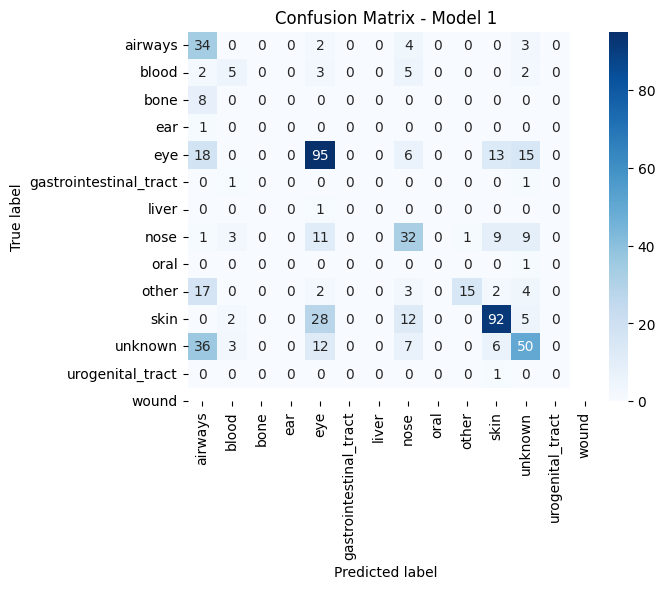

AUC: 0.9499652079789702


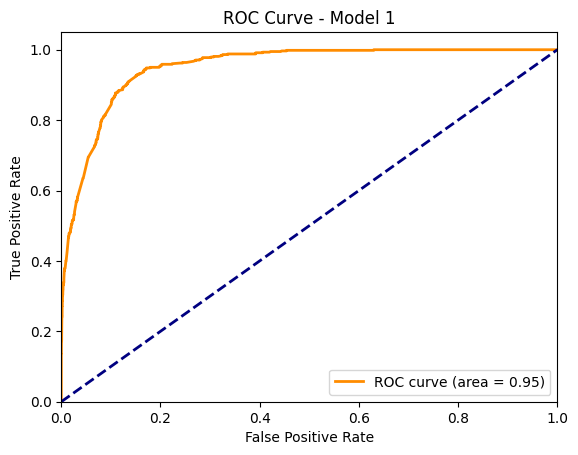

Model 2 Performance:
Accuracy: 0.5540308747855918
Classification Report:
                        precision    recall  f1-score   support

               airways       0.29      0.79      0.43        43
                 blood       0.36      0.29      0.32        17
                  bone       0.00      0.00      0.00         8
                   eye       0.00      0.00      0.00         1
gastrointestinal_tract       0.62      0.65      0.63       147
                 heart       0.00      0.00      0.00         2
           lymph_nodes       0.00      0.00      0.00         1
                  oral       0.46      0.48      0.47        66
                 other       0.00      0.00      0.00         1
                  skin       0.94      0.35      0.51        43
               unknown       0.75      0.66      0.70       139
      urogenital_tract       0.56      0.44      0.49       114
                 wound       0.00      0.00      0.00         1

              accuracy       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


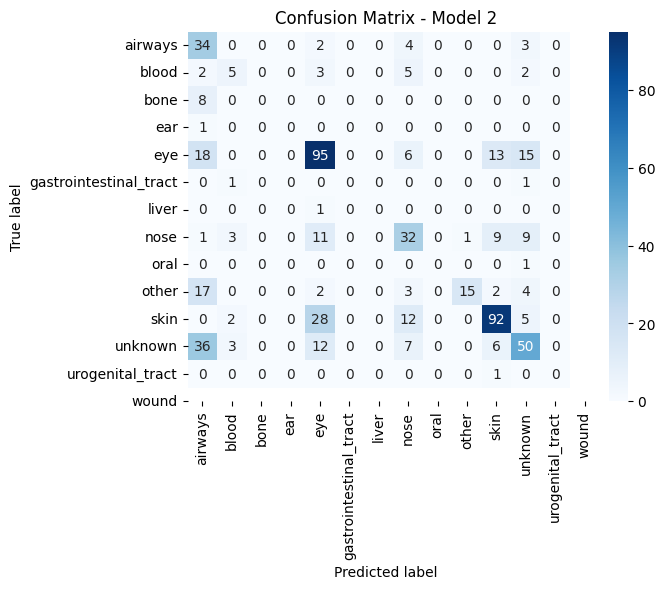

AUC: 0.9499652079789702


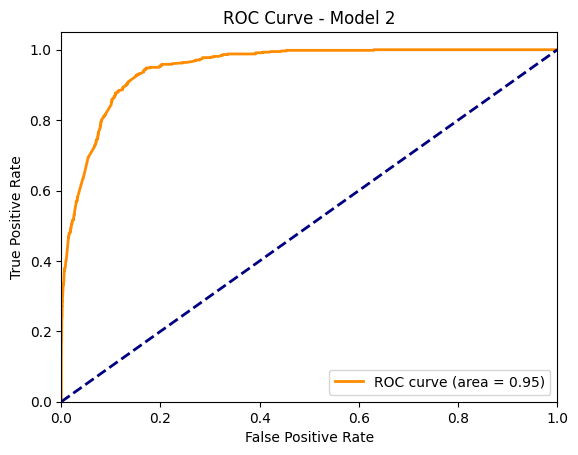

In [34]:
# 각 모델 평가 및 시각화
for idx, model, model_name in zip([1, 2], [model1, model2], ['Model 1', 'Model 2']):
    # 예측 디코딩
    predictions = label_encoder.inverse_transform(model.predict(X_test_body_site))
    accuracy = accuracy_score(y_test_body_site, predictions)

    print(f"{model_name} Performance:")
    print(f'Accuracy: {accuracy}')

    # Classification Report
    class_report = classification_report(y_test_body_site, predictions)
    print('Classification Report:')
    print(class_report)

    # 혼동 행렬
    cm = confusion_matrix(y_test_body_site, predictions)
    print('Confusion Matrix:')
    print(cm)
    plot_confusion_matrix(cm, classes=label_encoder.classes_, title=f'Confusion Matrix - {model_name}')

    # ROC Curve 및 AUC
    y_test_bin = label_binarize(y_test_body_site, classes=label_encoder.classes_)
    y_score = model.predict_proba(X_test_body_site)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # AUC 출력
    print(f'AUC: {roc_auc}')

    # ROC Curve 시각화
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
# 앙상블 모델 초기화
ensemble_model = VotingClassifier(estimators=[
    ('model1', model1),
    ('model2', model2)
], voting='soft')

In [26]:
# 앙상블 모델 훈련
ensemble_model.fit(X_train_body_site, y_body_site_encoded)

VotingClassifier(estimators=[('model1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            le...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_class=14,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [27]:
# 앙상블 모델 예측 및 성능 평가
ensemble_probabilities = ensemble_model.predict_proba(X_test_body_site)
ensemble_predictions = ensemble_probabilities.argmax(axis=1)  # 가장 높은 확률을 가진 클래스 선택

In [28]:
# 예측 디코딩
decoded_ensemble_predictions = label_encoder.inverse_transform(ensemble_predictions)

In [29]:
# 앙상블 모델 성능 출력
ensemble_accuracy = accuracy_score(y_test_body_site, decoded_ensemble_predictions)
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')

Ensemble Model Accuracy: 0.5540308747855918


In [30]:
# 앙상블 모델 분류 보고서 출력
ensemble_class_report = classification_report(y_test_body_site, decoded_ensemble_predictions)
print('Ensemble Model Classification Report:')
print(ensemble_class_report)

Ensemble Model Classification Report:
                        precision    recall  f1-score   support

               airways       0.29      0.79      0.43        43
                 blood       0.36      0.29      0.32        17
                  bone       0.00      0.00      0.00         8
                   eye       0.00      0.00      0.00         1
gastrointestinal_tract       0.62      0.65      0.63       147
                 heart       0.00      0.00      0.00         2
           lymph_nodes       0.00      0.00      0.00         1
                  oral       0.46      0.48      0.47        66
                 other       0.00      0.00      0.00         1
                  skin       0.94      0.35      0.51        43
               unknown       0.75      0.66      0.70       139
      urogenital_tract       0.56      0.44      0.49       114
                 wound       0.00      0.00      0.00         1

              accuracy                           0.55       583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ensemble Model AUC: 0.9499652079789702


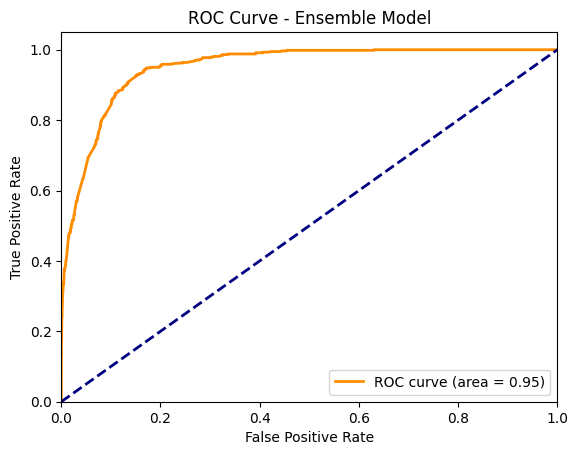

In [31]:
# 앙상블 모델 ROC Curve 및 AUC 출력
y_test_bin = label_binarize(y_test_body_site, classes=label_encoder.classes_)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test_bin.ravel(), ensemble_probabilities.ravel())
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# 앙상블 모델 AUC 출력
print(f'Ensemble Model AUC: {roc_auc}')

# 앙상블 모델 ROC Curve 시각화
plt.figure()
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend(loc="lower right")
plt.show()

Ensemble Model Confusion Matrix:
[[34  0  0  0  2  0  0  4  0  0  0  3  0]
 [ 2  5  0  0  3  0  0  5  0  0  0  2  0]
 [ 8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [18  0  0  0 95  0  0  6  0  0 13 15  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  3  0  0 11  0  0 32  0  1  9  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0]
 [17  0  0  0  2  0  0  3  0 15  2  4  0]
 [ 0  2  0  0 28  0  0 12  0  0 92  5  0]
 [36  3  0  0 12  0  0  7  0  0  6 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]]


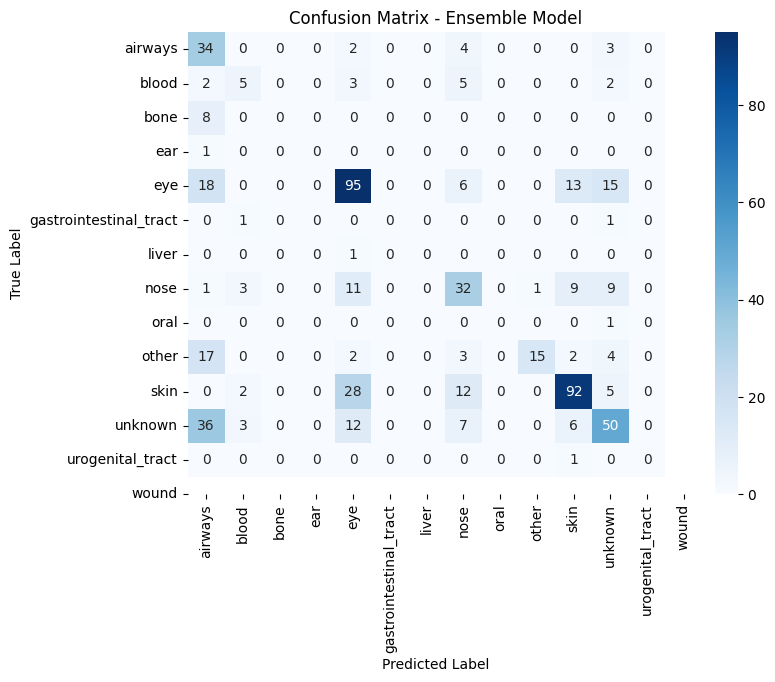

In [32]:
# 앙상블 모델 혼동 행렬 출력
ensemble_conf_matrix = confusion_matrix(y_test_body_site, decoded_ensemble_predictions)
print('Ensemble Model Confusion Matrix:')
print(ensemble_conf_matrix)

# 앙상블 모델 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()